# Optimizer-Method(Tensorflow)

In [1]:
import h5py
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from utils import random_miniBatch
import tensorflow as tf
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt

### Load Data Set

这里我们继续使用sklearn的"moons"数据

In [2]:
def load_dataset(n_sample):
    """
    Load data set.
    Argument:
    --------
        n_sample: number of sample.
    Returns:
    -------
        X: training data.
        y: training labels,the shape os (n_sample,1)
    """
    np.random.seed(3)
    X, y = datasets.make_moons(n_samples=n_sample, noise=.15) #300 #0.2 
    # Visualize the data
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5, cmap=plt.cm.Spectral);
    
    
    return X,y.reshape(-1,1)

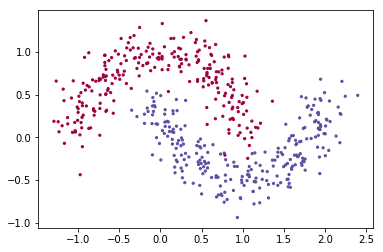

In [3]:
X,y = load_dataset(500)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Create Tensorflow Model

### 1.1 Initialization Parameters

初始化NN参数,其中$W$:Weights,$b$:Bias.

In [5]:
def init_parameters(L,layers):
    """
    Initialization Parameters
    
    Arguments:
    ---------
        L:Number of NN layers.
        layers:hidden layer's units + input layer units.
    Return:
    ------
        parameters: initialize parameters include weights and bias.
    """
    parameters = {}
    
    for l in range(L-1):
        W = tf.get_variable('W'+str(l+1),[layers[l],layers[l+1]],initializer=tf.contrib.layers.xavier_initializer(seed=1))
        b = tf.get_variable('b'+str(l+1),[1,layers[l+1]],initializer=tf.zeros_initializer())
        
        parameters['W'+str(l+1)] = W
        parameters['b'+str(l+1)] = b

    return parameters

### 1.2 Forward Propagation

构建FP,这里我们的output layers不使用sigmoid,因为我们是使用TF的```tf.nn.sigmoid_cross_entropy_with_logits```.

In [6]:
def forward(L,X,parameters):
    """
    
    """
    for l in range(L-1):
       
        W = parameters['W'+str(l+1)]
        b = parameters['b'+str(l+1)]
        
        X = tf.add(tf.matmul(X,W),b)
        
        if l != L - 2:
            X = tf.nn.relu(X)
        
    return X

### 1.3 Create Optimizer Model

这里我们开始建立模型,通过参数```mode```来选择不同的Optimizer.

[1] [SGD](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer?hl=en)

```python
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost)```

在Tensorflow中SGD是使用上诉代码,也就是说,只要我们传入的是Mini-Batchs的形式,那么实际上就是走的SGD.

[2] [Momentum](https://www.tensorflow.org/api_docs/python/tf/train/MomentumOptimizer?hl=en)

```python
optimizer = tf.train.MomentumOptimizer(learning_rate=lr,momentum=beta_momentum).minimize(cost)```

需要注意的是,TF将Momentum和NAG合并,通过调用参数```use_nesterov```来判断是否走NAG,默认为```False```.所以我们给出NAG的如下代码形式

[3] [Nesterov Accelerated Gradient](https://www.tensorflow.org/api_docs/python/tf/train/MomentumOptimizer?hl=en)

```python
optimizer = tf.train.MomentumOptimizer(learning_rate=lr,momentum=beta_momentum,use_nesterov=True).minimize(cost)```

[4] [Adagrad](https://www.tensorflow.org/api_docs/python/tf/train/AdagradOptimizer?hl=en)

```python
optimizer = tf.train.AdagradOptimizer(learning_rate=lr).minimize(cost)```

需要注意的是在TF中,Adagrad的初始化累积平方梯度```initial_accumulator_value```为0.1

[5] [Adadelta](https://www.tensorflow.org/api_docs/python/tf/train/AdadeltaOptimizer?hl=en)

```python
optimizer = tf.train.AdadeltaOptimizer(rho=0.9,learning_rate=lr).minimize(cost)```

对于Adadelta,需要注意一下两点:

(1) 在TF的Adadelta是和Kreas相似的,都有学习率```learning_rate```参数,默认值为0.001,根据官方的提示,如果你想按照原论文进行Adadelta,可以将其设置为1.

<img width=500 height=500 src="../../picture/116.png" />

(2) 衰减参数$\rho$的默认值为0.95,而我们这里选择0.9

[6] [RMSProp](https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer?hl=en)

```python
optimizer = tf.train.RMSPropOptimizer(learning_rate=lr).minimize(cost)```

其中```decay```参数默认为0.9.

[7] [Adam](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer?hl=en)

```python
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)```


其中```beta1=0.9,beta2=0.999```




In [19]:
def CreateOptimizerModel(layers,data,labels,val_data,val_labels,lr,epochs,batch_size,mode,beta_momentum=None):
    """
    Create Optimizer
    Arguments:
    ---------
        layers:hidden layer's units.
        data: training data.
        labels: training labels.
        val_data: validation data.
        val_labels: validation labels.
        lr: learning rate.
        epochs: #Iterate.
        batch_size: batch size using SGD.
        mode:can chosse
            1.SGD
            2.Momentum
            3.NAG
            4.Adagrad
            5.Adadelta
            6.RMSProp
            7.Adam
        beta_momentum: momentum optimizer parameters,default None. usually equal 0.9
        
    Note:
    ----
        Some Optimizer,I not set decay parameters,because the Tensorflow default value is my choice,such as RMSProp,Adam.
        
    """
    
    ops.reset_default_graph()
    
    m,n = data.shape
    n_classes = labels.shape[1]
    layers.insert(0,n)

    L = len(layers)
    X = tf.placeholder(tf.float32,[None,n],name='X_input')
    y = tf.placeholder(tf.float32,[None,n_classes],name='y_input')
    # initialization parameters
    parameters = init_parameters(L,layers)
    # forward propagation
    Z = forward(L,X,parameters)
  
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Z,labels=y))
    
    # choose mode...
    if mode == "SGD":
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(cost)
    elif mode == "Momentum":
        optimizer = tf.train.MomentumOptimizer(learning_rate=lr,momentum=beta_momentum).minimize(cost)
    elif mode == "NAG":
        optimizer = tf.train.MomentumOptimizer(learning_rate=lr,momentum=beta_momentum,use_nesterov=True).minimize(cost)
    elif mode == 'Adagrad':
        optimizer = tf.train.AdagradOptimizer(learning_rate=lr).minimize(cost)
    elif mode == "Adadelta":
        # learning  rate equal 1,means have not learning rate.
        optimizer = tf.train.AdadeltaOptimizer(rho=0.9,learning_rate=lr).minimize(cost)
    elif mode == "RMSProp":
        # using default decay=0.9
        optimizer = tf.train.RMSPropOptimizer(learning_rate=lr).minimize(cost)
    elif mode == "Adam":
        # beta_1=0.9,beta_2=0.999
        optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
        
    
    predict = tf.nn.sigmoid(Z)
    correct = tf.equal(tf.round(predict),y)
    accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
    
    init = tf.global_variables_initializer()
    seed = 0
    loss_vals = []
    loss_teains = []
    acc_trains = []
    acc_vals = []
    
    # start training...
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(epochs):
            seed +=1
            batchs = random_miniBatch(batch_size=batch_size,data=data,labels=labels,seed=seed)
            for mini_x,mini_y in batchs:
                _,loss = sess.run([optimizer,cost],feed_dict={X:mini_x,y:mini_y})
                
            if epoch % 400 == 0:
                acc_train = sess.run(accuracy,feed_dict={X:data,y:labels})
                acc_val = sess.run(accuracy,feed_dict={X:val_data,y:val_labels})
                val_loss = sess.run(cost,feed_dict={X:val_data,y:val_labels})
                
                loss_vals.append(val_loss)
                loss_teains.append(loss)
                acc_trains.append(acc_train)
                acc_vals.append(acc_val)
                
                print('[{}/{}] acc loss:{},acc train:{},val loss:{},acc val:{}\r'.format(epoch+400,
                                                                                      epochs,
                                                                                      loss,
                                                                                      acc_train,
                                                                                      val_loss,
                                                                                      acc_val),end="",flush=True)
        return loss_teains,loss_vals,acc_trains,acc_vals

### SGD

这里我们先使用SGD

(1) NN的结构为[20,7,5,1]

(2)学习率为0.0001

(3)迭代4000个epochs

(4)batch size 为64.

In [8]:
layers = [20,7,5,1]
loss_teains_SGD,loss_vals_SGD,acc_trains_SGD,acc_vals_SGD = CreateOptimizerModel(layers=layers,
                                                                                 data=X_train,
                                                                                 labels=y_train,
                                                                                 val_data=X_test,
                                                                                 val_labels=y_test,
                                                                                 lr=0.0001,
                                                                                 epochs=4000,
                                                                                 batch_size=64,
                                                                                 mode='SGD')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


### Momentum 

学习率和迭代次数epochs不变,decay momentum 设置为论文建议值0.9

In [9]:
layers = [20,7,5,1]
loss_teains_Momentum,loss_vals_Momentum,acc_trains_Momentum,acc_vals_Momentum=CreateOptimizerModel(layers=layers,
                                                                                                     data=X_train,
                                                                                                     labels=y_train,
                                                                                                     val_data=X_test,
                                                                                                     val_labels=y_test,
                                                                                                     lr=0.0001,
                                                                                                     epochs=4000,
                                                                                                     batch_size=64,
                                                                                                     mode='Momentum',
                                                                                                     beta_momentum=0.9)


### Nesterov Accelerated Gradient

设置的参数和Momentum是一致的,只是在Optimizer中选择```use_nesterov=True```.

In [10]:
layers = [20,7,5,1]
loss_teains_NAG,loss_vals_NAG,acc_trains_NAG,acc_vals_NAG=CreateOptimizerModel(layers=layers,data=X_train,
                                                                                                     labels=y_train,
                                                                                                     val_data=X_test,
                                                                                                     val_labels=y_test,
                                                                                                     lr=0.0001,
                                                                                                     epochs=4000,
                                                                                                     batch_size=64,
                                                                                                     mode='NAG',
                                                                                                     beta_momentum=0.9)




### Adagrad

使用论文建议的学习率0.01,当然这不是绝对的.

In [11]:
layers = [20,7,5,1]
loss_teains_Adagrad,loss_vals_Adagrad,acc_trains_Adagrad,acc_vals_Adagrad=CreateOptimizerModel(layers=layers,data=X_train,
                                                                                                     labels=y_train,
                                                                                                     val_data=X_test,
                                                                                                     val_labels=y_test,
                                                                                                     lr=0.01,
                                                                                                     epochs=4000,
                                                                                                     batch_size=64,
                                                                                                     mode='Adagrad')



### Adadelta

这里我们设置学习率为1,意味着我们不使用学习率.

In [12]:
layers = [20,7,5,1]
loss_teains_Adadelta,loss_vals_Adadelta,acc_trains_Adadelta,acc_vals_Adadelta=CreateOptimizerModel(layers=layers,
                                                                                                data=X_train,
                                                                                                lr=1.0,
                                                                                                labels=y_train,
                                                                                                val_data=X_test,
                                                                                                val_labels=y_test,
                                                                                                epochs=4000,
                                                                                                batch_size=64,
                                                                                                mode='Adadelta')


### RMSProp

使用PPT给予的建议学习率0.001

In [13]:
layers = [20,7,5,1]
loss_teains_RMSProp,loss_vals_RMSProp,acc_trains_RMSProp,acc_vals_RMSProp=CreateOptimizerModel(layers=layers,
                                                                                                data=X_train,
                                                                                                lr=0.001,
                                                                                                labels=y_train,
                                                                                                val_data=X_test,
                                                                                                val_labels=y_test,
                                                                                                epochs=4000,
                                                                                                batch_size=64,
                                                                                                mode='RMSProp')

### Adam

使用论文建议的学习率0.001

In [14]:
layers = [20,7,5,1]
loss_teains_Adam,loss_vals_Adam,acc_trains_Adam,acc_vals_Adam=CreateOptimizerModel(layers=layers,
                                                                                                data=X_train,
                                                                                                lr=0.001,
                                                                                                labels=y_train,
                                                                                                val_data=X_test,
                                                                                                val_labels=y_test,
                                                                                                epochs=4000,
                                                                                                batch_size=64,
                                                                                                mode='Adam')

### Plot Loss And Accuracy

### 1.1 Training/Validation Loss

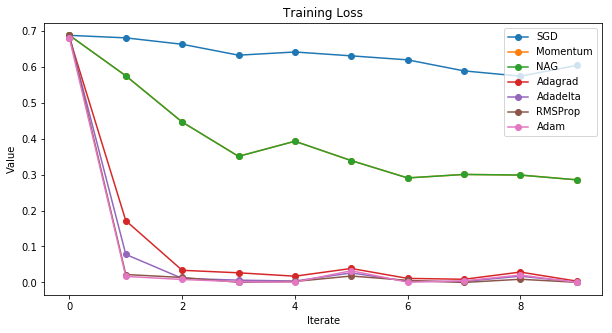

In [21]:
figure = plt.figure(figsize=(10,5))
plt.plot(loss_teains_SGD,'-o',label="SGD")
plt.plot(loss_teains_Momentum,'-o',label="Momentum")
plt.plot(loss_teains_NAG,'-o',label="NAG")
plt.plot(loss_teains_Adagrad,'-o',label="Adagrad")
plt.plot(loss_teains_Adadelta,'-o',label="Adadelta")
plt.plot(loss_teains_RMSProp,'-o',label="RMSProp")
plt.plot(loss_teains_Adam,'-o',label="Adam")
plt.title('Training Loss')
plt.xlabel('Iterate')
plt.ylabel('Value')
plt.legend()
plt.show()

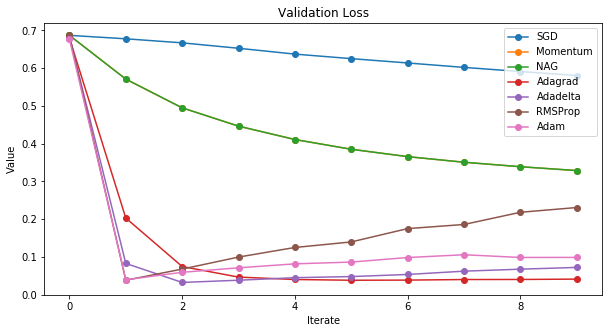

In [22]:
figure = plt.figure(figsize=(10,5))
plt.plot(loss_vals_SGD,'-o',label="SGD")
plt.plot(loss_vals_Momentum,'-o',label="Momentum")
plt.plot(loss_vals_NAG,'-o',label="NAG")
plt.plot(loss_vals_Adagrad,'-o',label="Adagrad")
plt.plot(loss_vals_Adadelta,'-o',label="Adadelta")
plt.plot(loss_vals_RMSProp,'-o',label="RMSProp")
plt.plot(loss_vals_Adam,'-o',label="Adam")
plt.title('Validation Loss')
plt.xlabel('Iterate')
plt.ylabel('Value')
plt.legend()
plt.show()

可以看到训练样本的损失随着Optimizer的"升级",损失逐渐下降.不过对于Validation data而言,貌似RMSProp,Adam,Adadlta有点过拟合的发生在2个epoch的时候.其中Adagrad还是比较稳定的,当然这只是针对于现在这个网络整体结构而言.并不意味着RMSProp,Adam,Adadlta就不如Adadelta差.

### 1.2  Training/Validation Accuracy

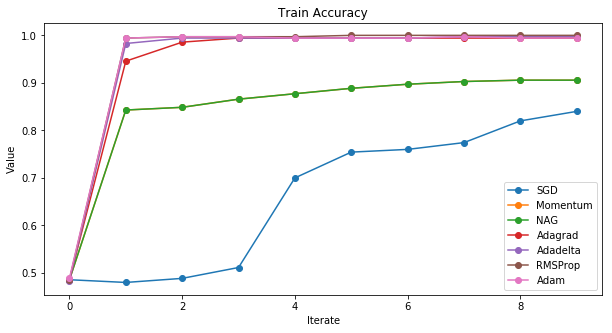

In [17]:
figure = plt.figure(figsize=(10,5))
plt.plot(acc_trains_SGD,'-o',label="SGD")
plt.plot(acc_trains_Momentum,'-o',label="Momentum")
plt.plot(acc_trains_NAG,'-o',label="NAG")
plt.plot(acc_trains_Adagrad,'-o',label="Adagrad")
plt.plot(acc_trains_Adadelta,'-o',label="Adadelta")
plt.plot(acc_trains_RMSProp,'-o',label="RMSProp")
plt.plot(acc_trains_Adam,'-o',label="Adam")
plt.title('Train Accuracy')
plt.xlabel('Iterate')
plt.ylabel('Value')
plt.legend()
plt.show()

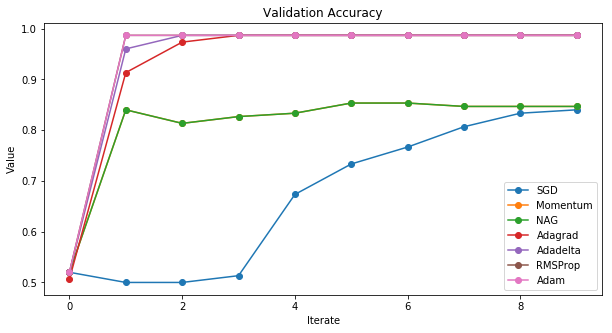

In [23]:
figure = plt.figure(figsize=(10,5))
plt.plot(acc_vals_SGD,'-o',label="SGD")
plt.plot(acc_vals_Momentum,'-o',label="Momentum")
plt.plot(acc_vals_NAG,'-o',label="NAG")
plt.plot(acc_vals_Adagrad,'-o',label="Adagrad")
plt.plot(acc_vals_Adadelta,'-o',label="Adadelta")
plt.plot(acc_vals_RMSProp,'-o',label="RMSProp")
plt.plot(acc_vals_Adam,'-o',label="Adam")
plt.title('Validation Accuracy')
plt.xlabel('Iterate')
plt.ylabel('Value')
plt.legend()
plt.show()

可以看到出了SGD和Momentum,其他Optimizer的效果都还不错.需要注意的是,对当前样本和网络而言,Momentum和NAG的效果是一样的,所以这里少了一条线(Momentum).

# Summary

实际上选择什么Optimizer是根据网络结构和数据本身而言的,各有各的优势.另外在很多框架下,Momentum和NAG都是合并的.